# Random Forest - Low Depth
As part of the overall stacking model, I will develop two Random Forest (RF) models: one with a relative low depth, and one with a high depth. I define low depth as `max_depth = 5` and high depth as `max_depth = 15`. With the depth defined, I tune the remaining parameters sequentially.  
  
In this notebook, I set out to optimise a **low depth RF model**.

In [1]:
# Import modules
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.manifold import Isomap
from sklearn.metrics import accuracy_score, auc, make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RepeatedKFold, KFold, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, Normalizer, RobustScaler
import warnings

# Settings
%matplotlib inline
matplotlib.style.use('ggplot')
warnings.filterwarnings('ignore')

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Prepare Data

In [2]:
# Import data
df = pd.read_csv('train_clean.csv')

# Data and labels
X = df.drop('Survived', axis = 1)
X = pd.get_dummies(X)
y = df['Survived']

## Global Settings and Functions

In [3]:
# Repeated 5-fold validation
rkf = RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=123)

# Function to extract CV test results
def gaia_get_test(cv_object, params, title = 'Test Scores vs. Parameter'):
    
    # Extract test scores
    temp_test = cv_object.cv_results_['mean_test_score']
    
    # Plot
    plt.plot(params, temp_test)
    plt.title(title)
    plt.show()

## Low Depth

### Iteration 1: Optimise No. of Trees
With `max_depth = 5`, the optimal number of trees was 1,000. Although accuracy was increasing from 2500 to 3000, this would be computationally too intensive.

In [4]:
# Define parameters
param_n_estimators = [100, 250, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
params = {
    'n_estimators': param_n_estimators
}

In [5]:
# Create RF model
rf_low = GridSearchCV(
    estimator = RandomForestClassifier(
        max_depth = 5,
        oob_score = True,
        random_state = 123,
        n_jobs = 3
    ),
    param_grid = params,
    n_jobs = 3,
    cv = rkf,
    verbose = 3
)

# Train model
rf_low.fit(X, y)

Fitting 25 folds for each of 8 candidates, totalling 200 fits


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   13.6s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  1.8min
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:  5.5min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x00000241CCD50F98>,
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=3,
            oob_score=True, random_state=123, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'n_estimators': [100, 250, 500, 1000, 1500, 2000, 2500, 3000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [6]:
# Print results
print('Best Score: ' + str(rf_low.best_score_))
print('Best Params: ' + str(rf_low.best_params_))

Best Score: 0.8336700336700337
Best Params: {'n_estimators': 3000}


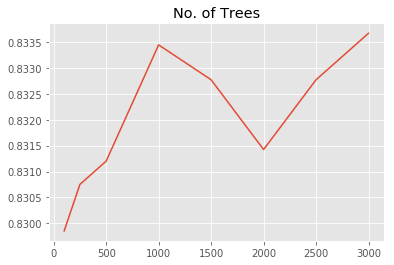

In [7]:
# Plot results
gaia_get_test(rf_low, param_n_estimators, 'No. of Trees')

### Iteration 2: Run RFECV
The optimal number of features to be selected was 34. We use these 34 features in subsequent models.

In [8]:
# Create model
rf_low = RFECV(
    estimator = RandomForestClassifier(random_state=123, max_depth=5, n_estimators=1000, n_jobs = 3),
    cv = rkf,
    verbose = 2,
    n_jobs = 3
)

# Fit model
rf_low.fit(X, y)

RFECV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x00000241CCD50F98>,
   estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=3,
            oob_score=False, random_state=123, verbose=0, warm_start=False),
   n_jobs=3, scoring=None, step=1, verbose=2)

In [9]:
# Results of RFE
print('No. of Features: ' + str(rf_low.n_features_))
print('Feature Ranking:')
rfe_feats = pd.DataFrame(rf_low.ranking_, columns = ['rank'])
rfe_feats['feature'] = X.columns
rfe_feats.sort_values(by = 'rank')

No. of Features: 34
Feature Ranking:


,rank,feature
0,1,pclass_OC
46,1,cabletter_OH_B/D/E
30,1,age_OH_A1
29,1,sex_OH_male
28,1,sex_OH_female
47,1,cabletter_OH_NIL
26,1,title_OH_Mrs.
25,1,title_OH_Mr.
24,1,title_OH_Miss.
23,1,title_OH_Master.


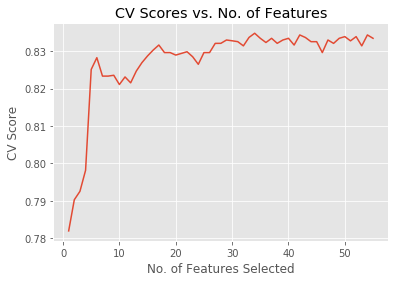

In [10]:
# Plots
plt.figure()
plt.title('CV Scores vs. No. of Features')
plt.xlabel("No. of Features Selected")
plt.ylabel("CV Score")
plt.plot(range(1, len(rf_low.grid_scores_) + 1), rf_low.grid_scores_)
plt.show()

### Subset Features
The line below determines how strictly we adhere to the results of RFECV. Rank 1 features are arguably the top-notch ones. However, it is worth experimenting with features in the lower ranks.

In [11]:
# Subset features
X_sub = X.iloc[:, (rf_low.ranking_ == 1)]

### Iteration 3: Optimise Max Features

In [12]:
# Define parameters
param_max_feat = np.arange(2, X_sub.shape[1], 1)
params = {
    'max_features': param_max_feat
}

In [ ]:
# Create RF model
rf_low = GridSearchCV(
    estimator = RandomForestClassifier(
        max_depth = 5,
        n_estimators = 1000,
        oob_score = True,
        random_state = 123,
        n_jobs = 3
    ),
    param_grid = params,
    n_jobs = 3,
    cv = rkf,
    verbose = 3
)

# Train model
rf_low.fit(X_sub, y)

Fitting 25 folds for each of 32 candidates, totalling 800 fits


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   41.6s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  3.0min
[Parallel(n_jobs=3)]: Done 282 tasks      | elapsed:  7.3min
[Parallel(n_jobs=3)]: Done 506 tasks      | elapsed: 12.7min


In [15]:
# Print results
print('Best Score: ' + str(rf_low.best_score_))
print('Best Params: ' + str(rf_low.best_params_))

Best Score: 0.837037037037037
Best Params: {'max_features': 14}


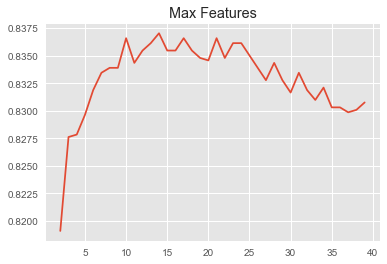

In [16]:
# Plot results
gaia_get_test(rf_low, param_max_feat, 'Max Features')

### Iteration 4: Optimise Minimum Samples in Terminal Nodes

In [18]:
# Define parameters
param_min_leaf = [1,5,10,20,30,40,50]
params = {
    'min_samples_leaf': param_min_leaf
}

In [19]:
# Create RF model
rf_low = GridSearchCV(
    estimator = RandomForestClassifier(
        max_depth = 5,
        n_estimators = 1000,
        max_features = 6,
        oob_score = True,
        random_state = 123,
        n_jobs = 3
    ),
    param_grid = params,
    n_jobs = 3,
    cv = rkf,
    verbose = 3
)

# Train model
rf_low.fit(X, y)

Fitting 25 folds for each of 7 candidates, totalling 175 fits


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   31.0s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  2.4min
[Parallel(n_jobs=3)]: Done 175 out of 175 | elapsed:  3.4min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x00000207A5C04A90>,
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=3,
            oob_score=True, random_state=123, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'min_samples_leaf': [1, 5, 10, 20, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [20]:
# Print results
print('Best Score: ' + str(rf_low.best_score_))
print('Best Params: ' + str(rf_low.best_params_))

Best Score: 0.8318742985409652
Best Params: {'min_samples_leaf': 1}


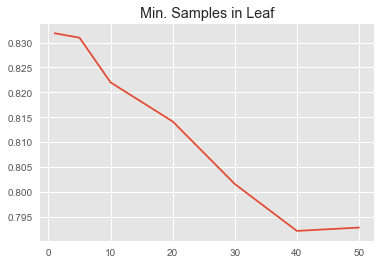

In [21]:
# Plot results
gaia_get_test(rf_low, param_min_leaf, 'Min. Samples in Leaf')

### Iteration 5: Optimise Criterion

In [22]:
# Define parameters
param_criterion = ['gini', 'entropy']
params = {
    'criterion': param_criterion
}

In [23]:
# Create RF model
rf_low = GridSearchCV(
    estimator = RandomForestClassifier(
        max_depth = 5,
        n_estimators = 1000,
        max_features = 6,
        min_samples_leaf = 10,
        oob_score = True,
        random_state = 123,
        n_jobs = 3
    ),
    param_grid = params,
    n_jobs = 3,
    cv = rkf,
    verbose = 3
)

# Train model
rf_low.fit(X, y)

Fitting 25 folds for each of 2 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   36.7s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  1.1min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x00000207A5C04A90>,
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=3,
            oob_score=True, random_state=123, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [24]:
# Print results
print('Best Score: ' + str(rf_low.best_score_))
print('Best Params: ' + str(rf_low.best_params_))

Best Score: 0.8240179573512907
Best Params: {'criterion': 'entropy'}


In [25]:
# Print
print('Gini: ' + str(rf_low.cv_results_['mean_test_score'][0]))
print('Entropy: ' + str(rf_low.cv_results_['mean_test_score'][1]))

Gini: 0.8219977553310887
Entropy: 0.8240179573512907


### Iteration 6: Optimise Minimum Samples for Split

In [26]:
# Define parameters
param_min_split = [10,20,30,40,50,75,100]
params = {
    'min_samples_split': param_min_split
}

In [27]:
# Create RF model
rf_low = GridSearchCV(
    estimator = RandomForestClassifier(
        max_depth = 5,
        n_estimators = 1000,
        max_features = 6,
        min_samples_leaf = 10,
        criterion = 'entropy',
        oob_score = True,
        random_state = 123,
        n_jobs = 3
    ),
    param_grid = params,
    n_jobs = 3,
    cv = rkf,
    verbose = 3
)

# Train model
rf_low.fit(X, y)

Fitting 25 folds for each of 7 candidates, totalling 175 fits


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   32.1s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  2.5min
[Parallel(n_jobs=3)]: Done 175 out of 175 | elapsed:  3.6min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x00000207A5C04A90>,
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=3,
            oob_score=True, random_state=123, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'min_samples_split': [10, 20, 30, 40, 50, 75, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [28]:
# Print results
print('Best Score: ' + str(rf_low.best_score_))
print('Best Params: ' + str(rf_low.best_params_))

Best Score: 0.8240179573512907
Best Params: {'min_samples_split': 10}


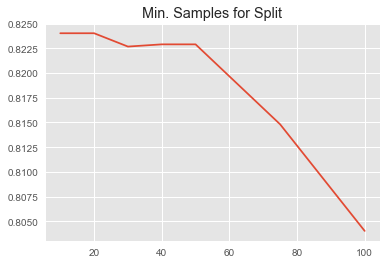

In [29]:
# Plot results
gaia_get_test(rf_low, param_min_split, 'Min. Samples for Split')

### Iteration 7: Optimise